In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 27 17:04:01 2018

@author: 54326
"""

from math import sqrt
from copy import deepcopy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
def lc_plot(estimator, factor_return, size, min_spread=0.001, k_cvs=10):
    '''
    绘制学习曲线，选择合适的训练集大小
    Args:
        factor_return:
            因子排名前50的成分股的日收益率的均值，
            此外必须包含'spread'数据，才能实现剔除涨跌幅差过小的样本，类别标签在最后一列
        size:
            训练集大小的上限
        min_spread:
            最小的涨跌幅差，表示剔除训练集中涨跌幅差过小的样本的阈值，取值应大于等于0，默认值为0.001
        k_cvs:
            交叉验证的折数
    Return:
        输出一个正确率与训练集大小的变化图
    '''
    train = factor_return.iloc[:size, :]
    if min_spread:# 剔除训练集中涨跌幅差绝对值小于min_spread的样本
        train = train[abs(train['spread']) >= min_spread] 
    X_train = train.iloc[:, :-1]
    Y_train = train.iloc[:, -1] 
    X_train.drop(labels='spread', axis=1, inplace=True)
        
    train_size, train_score, test_score = learning_curve(estimator, X_train, Y_train, 
                                                         train_sizes=np.linspace(0.1, 1, 10), 
                                                         cv=k_cvs, n_jobs=-1)

    plt.plot(train_size, train_score.mean(1), '-bo', label='train accuracy')
    plt.plot(train_size, test_score.mean(1), '--gs', label='test accuray')
    plt.legend()
    plt.xlabel('train size')

In [3]:
	
class Predict():

    def __init__(self, estimator, factor_return, size, span, last, min_spread=0.001):
        self.estimator = estimator
        self.factor_return = factor_return
        self.size = size # 训练集大小
        self.span = span # 多少个交易日更新一次模型的参数
        self.last = last
        self.min_spread = min_spread # 最小涨跌幅差
        self.total_size = len(self.factor_return) # 整个数据集的大小
        self.years = (self.total_size - self.size) // self.span + 1 #数据集的大致年数
        
    def split(self, i):
        '''
        训练集与测试集的分割，类别标签在最后一列
        Args：
            i:
                第几个span
            min_spread:
                最小的涨跌幅差，表示剔除训练集中涨跌幅差过小的样本的阈值，取值应大于等于0，默认值为0.001
        Returns:
            x_train, y_train, x_test, y_test
        '''
        factor_return = self.factor_return
        span = self.span
        size = self.size
        min_spread = self.min_spread
        
        train = factor_return.iloc[i*span : size + i*span, :]
        if min_spread:# 删除训练集中涨跌幅差的绝对值小于min-spread的样本
            train = train[abs(train['spread']) >= min_spread] 
        x_train = train.iloc[:, :-1]
        y_train = train.iloc[:, -1]
        x_test = factor_return.iloc[size + i*span : size + (i+1)*span:, :-1]
        y_test = factor_return.iloc[size + i*span : size + (i+1)*span:, -1]
        x_train.drop(labels='spread', axis=1, inplace=True)
        x_test.drop(labels='spread', axis=1, inplace=True)
        sc = StandardScaler()
        sc.fit(x_train)# 对特征进行标准化
        x_train = sc.transform(x_train) 
        x_test = sc.transform(x_test)
        return x_train, y_train, x_test, y_test

    def gs_bests(self, params_dict, k_cvs=5, pre_dispatches=20):
        '''
        网格搜索
        Args:
            params_dict:
                以待优化的参数为键的字典
            k_cvs:
                网格搜索时进行交叉验证的折数
        Return:
            嵌套字典
        '''
        gscv = GSCV(self.estimator, param_grid=params_dict, cv=k_cvs, 
                    n_jobs=-1, pre_dispatch=pre_dispatches)
        years = self.years
        last = self.last
        bests = {}
        up_limits = {}
        low_limits = {}
        for i in range(years - last, years):
            x_train, y_train, *test = self.split(i) # 分割训练集合测试集
            gscv.fit(x_train, y_train)
            params = gscv.best_params_
            bests[i-(years-last)] = params # 拟合分类器，并保存
            # 统计参数触及上下边界鹅情况
            for param in params:
                value = params[param]
                upper = pd.Series(params_dict[param]).max()
                lower = pd.Series(params_dict[param]).min()
                if value == upper:
                    up_limits[param] = up_limits.get(param, 0) + 1
#                     print('%s touched upper limit' % param)
                elif value == lower:
                    low_limits[param] = low_limits.get(param, 0) + 1
#                     print('%s touched lower limit' % param)
                else:
                    pass 
        if up_limits:
            print('upper limits:')
            for param in up_limits:
                print(param, 'touch upper limit:', up_limits[param])
        if low_limits:
            print('lower limits:')
            for param in low_limits:
                print(param, 'touch lower limit:', low_limits[param])
        print('\n')
        return bests
    
    def best_estimators(self, best_params):
        '''
        将最优参数代入得到带参数的估计器
        '''
        years = self.years
        last = self.last
        ests = {}
        for i in range(years - last, years):
            x_train, y_train, *test = self.split(i)
            est = self.estimator.set_params(**best_params[i-(years-last)])
            ests[i-(years-last)] =  deepcopy(est.fit(x_train, y_train))
        return ests
    
    def estimators(self):
        '''
        估计分类器的参数，并保存到一个字典
        '''
        years = self.years
        last = self.last
        ests = {}
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i) # 分割训练集合测试集
            ests[i-(years-last)] =  deepcopy(self.estimator.fit(x_train, y_train)) # 拟合分类器，并保存
        return ests
    
    def coeficients(self, estimators):
        '''
        获得拟合的系数，返回一个Series
        '''
        names = self.factor_return.columns.tolist()[:-2]
        coefs = pd.concat([pd.Series(estimators[i].coef_[0], index=names).abs() 
                           for i in range(len(estimators))], axis=1).T.mean() # 所有分类器的特征的系数
        return coefs
    
    def feature_importances(self, estimators):
        '''
        随机森林的特征重要性，返回一个Series
        '''
        names = self.factors.columns.tolist()[:-1]
        fis = pd.concat([pd.Series(estimators[i].feature_importances_, index=names).abs() 
                         for i in range(len(estimators))], axis=1).T.mean() # 所有分类器的特征的系数的均值
        return fis
    
    def predicts(self, estimators):
        '''
        预测类别，返回一个DataFrame，含有两列，第一列表示预测的类别'predict'，第二列表示对应的概率'proba'
        '''
        years = self.years
        last = self.last
        predict = defaultdict(dict)
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]
            predict[i]['predict'] = est.predict(x_test) # 预测类别
#             predict[i]['proba'] = est.predict_proba(x_test)[:, 1] # 预测的概率
            predict[i]['proba'] = np.where(predict[i]['predict'] == 1, 
                                           est.predict_proba(x_test)[:, 1],  
                                           est.predict_proba(x_test)[:, 0])# 预测的概率
            predict[i]['datetime'] = y_test.index
        predicts = pd.concat([pd.DataFrame(predict[i]) for i in range(years-last, years)])
        predicts.set_index('datetime', inplace=True)
        return predicts
    
    def trade_records(self, predicts, min_proba=0):
        '''
        根据预测的类别和设定的最小概率的阈值，确定交易
        Args：
            predicts:
                predict方法产生的结果，包含预测的类别标签和对应的概率
            min_proba:
                设定的最小概率的阈值，大于该阈值时才进行交易，一般要大于0.5才会真正起到限制作用
        Returns:
            返回一个交易记录的标签，值为1，-1，0
        '''
        Y_test = self.factor_return.loc[self.factor_return.index[self.size]:, 'hs_zz']
        labels = predicts.join(Y_test)
        # 交易记录，如果概率大于min_proba且类别预测正确，则记录为1，表示获利交易；
        # 如果概率大于min_proba且类别预测错误，则记录为-1，表示亏损交易；
        # 其他记录为0，表示没有交易
        labels['record'] = np.where((labels['proba'] >= min_proba) & 
                                    (labels['hs_zz'] == labels['predict']), 1, 
                                    np.where((labels['proba'] >= min_proba) & 
                                             (labels['hs_zz'] != labels['predict']), -1, 0)) 
        labels['record'] = labels['record'].shift(1) # 将记录移至一个交易日
        labels.dropna(inplace=True)
        return labels.loc[:, ['record', 'proba']]
    
    def confusion(self, predicts):
        '''
        返回混淆矩阵
        '''
        Y_test = self.factor_return.loc[self.factor_return.index[self.size]:, 'hs_zz']
        labels = predicts.join(Y_test)
        confmat = confusion_matrix(labels['hs_zz'], labels['predict'])
        
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

        plt.xlabel('predicted label')
        plt.ylabel('true label')
        
    def scores(self, estimators):
        '''
        计算预测的正确率
        '''
        factor_return = self.factor_return
        size = self.size
        span = self.span
        total_size = self.total_size
        years = self.years
        last = self.last
        
        scores_ = defaultdict(dict)
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]        
#            test_begin = factor_return.index[size + i*span].strftime('%Y-%m')
            if size + (i+1)*span <= total_size:
                end_idx = size + (i+1)*span
            else:
                end_idx = total_size - 1
            test_end = factor_return.index[end_idx].strftime('%Y-%m')
            scores_[test_end]['train'] = est.score(x_train, y_train)
            scores_[test_end]['test'] = est.score(x_test, y_test)
        return scores_
    
    def roc_plot(self, estimators, pos_label=1):
        '''
        绘制ROC曲线
        '''
        years = self.years
        last = self.last
        plt.figure(figsize=(8, 6))
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]
            fpr, tpr, _ = roc_curve(y_test, est.decision_function(x_test), pos_label=pos_label)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='%s span, area = %.2f' % (i-(years-last), roc_auc))
        
            if i == years - 1:
                plt.plot([0, 1], [0, 1], linestyle='--', marker='o', color='black', label='random guessing')
                plt.legend()

In [4]:
				
def maxdd(nav):
    '''
    根据净值序列计算最大回撤序列
    '''
    DD = []
    for i in range(1, len(nav)):
        max_i = max(nav[:i+1])
        DD.append((nav[i] - max_i) / max_i)
    return pd.Series(DD, index=nav.index[1:], name='max drawdown')

def scores_plot(scores):
    '''
    绘制预测正确率的变化图
    '''
    scores = pd.DataFrame(scores).T
    scores.index.names = ['begin', 'end']
    scores = scores.loc[:, ['train', 'test']]
    plt.figure()
    scores.plot(marker='o', figsize=(8, 6))
    plt.xticks(range(len(scores)), scores.index)
    plt.xlabel('begin end')
    plt.ylabel('accuracy')

def get_nav(record, retn, trans_cost=0, slippage=0):
    '''
    计算净值
    '''
    test_retn = pd.concat([record, retn], axis=1, join='inner')
    if slippage:
        trans_cost += slippage # 将滑点算入交易成本
    # 交易收益等于交易记录标签与实际收益率的乘积
    test_retn['l_s'] = np.where(test_retn['record'] != 0, 
                                test_retn['record'] * abs(test_retn[retn.name]) - trans_cost, 0) 
    test_retn['nav'] = test_retn['l_s'].cumsum() + 1 # 累计收益率
#    test_retn['nav'] = (1 + test_retn['l_s']).cumprod() # 累乘
    return test_retn#['nav']

def evaluate(nav, year_days=242):
    '''
    计算最大回撤，年化收益率，calmar比率等评价指标
    '''
    mdd = maxdd(nav.nav) # 最大回撤
    nav['duration'] = 0
    duration_idx = nav.columns.tolist().index('duration')
    # 计算最大回撤期
    for i in range(1, len(nav)):
        if mdd[i-1] == 0:
            nav.iloc[i, duration_idx] = 0
        else:
            nav.iloc[i, duration_idx] = nav.iloc[i-1, duration_idx] + 1
    ann = (nav.nav[-1] / nav.nav[0]) ** (year_days / len(nav)) - 1 # 年化收益率
    calmar = abs(ann / mdd.min()) # calmar比率
    nav['e'] = (nav.l_s - (0.03 / year_days))
    sharpe = nav.e.mean() / nav.e.std() * sqrt(year_days)
    win = len(nav[nav.l_s > 0]) / len(nav.l_s != 0)
    return nav['duration'].max(), mdd, ann, calmar, sharpe, win

def nav_plot(nav, min_spread=0, min_proba=0, quantile=0, trans_cost=0):
    '''
    绘制回测曲线图
    '''
    mddd, mdd, ann, calmar, sharpe, win = evaluate(nav)
    ddd_idx = nav['duration'].idxmax()
    ddd_begin = nav.loc[:ddd_idx, 'nav'].idxmax()
    ddd_center = nav.index[(len(nav.loc[:ddd_begin, :]) + len(nav.loc[:ddd_idx, :])) // 2]
    dd_idx = mdd.idxmin()
    dd_begin = nav.loc[:dd_idx, 'nav'].idxmax()
    fig, ax = plt.subplots(figsize=(15, 6))
    idx = nav.index
    ax.plot(idx, nav.nav)
    ax.set_xlim(idx[0], idx[-1])
    ax.set_ylabel('Net Aseet Value')
    offset = (nav.nav.max() - nav.nav.min()) / 20
    ax.annotate("", xy=(ddd_idx, nav.nav[ddd_begin]), xycoords='data',
                 xytext=(ddd_begin, nav.nav[ddd_begin]), textcoords='data',
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(ddd_center, nav.nav[ddd_begin]+offset, 'max drawdown duration', 
            {'color': 'k', 'fontsize': 12, 'ha': 'center', 'va': 'top',})
    ax.annotate("", xy=(dd_idx, nav.nav[dd_begin]), xycoords='data', 
                xytext=(dd_idx, nav.nav[dd_idx]), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(dd_idx, nav.nav[dd_idx]-offset, 'max drawdown',
            {'color': 'k', 'fontsize': 12, 'ha': 'center', 'va': 'bottom',})
    ax2 = ax.twinx()
    ax2.set_ylim(-1, 0)
    ax2.plot(mdd, color='c')
    ax2.fill_between(mdd.index, mdd, color='c')
    ax2.set_ylabel('Max Drawdown')
    ax2.text(ax2.get_xbound()[0]+50, -0.98, 
             'trans_cost: %.4f, quantile: %d, min_proba: %.4f, Max Drawdwon Duration: %d, Max Drawdown: %.2f%%, Annual: %.2f%%, Calmar: %.2f, sharpe: %.2f, win: %.2f' % 
             (trans_cost, quantile, min_proba, mddd, mdd.min() *100, ann*100, calmar, sharpe, win))

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from sklearn.svm import SVC

In [8]:
with pd.HDFStore('E:/data/factor_return.h5') as store:
    retn = store['factor_return']

In [9]:
with pd.HDFStore('E:/data/hs_zz.h5') as store:
    print(store.info())
    hs_zz = store['hs_zz']

<class 'pandas.io.pytables.HDFStore'>
File path: E:/data/hs_zz.h5
/factor_data                     frame        (shape->[5775034,14])
/factor_return_bottom            frame        (shape->[2867,11])   
/factor_return_top               frame        (shape->[2867,17])   
/hs_zz                           frame        (shape->[2888,8])    
/zz800s                          frame        (shape->[3685743,8]) 


In [10]:
data_ = retn.join(hs_zz.loc[:, ['spread', 'hs_zz']])

In [11]:
data_.columns

Index(['Beta', 'Size', 'Momentum', 'ResidualVolatility', 'NLSize', 'Value',
       'Liquidity', 'EarningsYield', 'Growth', 'Leverage', 'SW801010',
       'SW801020', 'SW801030', 'SW801040', 'SW801050', 'SW801080', 'SW801110',
       'SW801120', 'SW801130', 'SW801140', 'SW801150', 'SW801160', 'SW801170',
       'SW801180', 'SW801200', 'SW801210', 'SW801230', 'SW801710', 'SW801720',
       'SW801730', 'SW801740', 'SW801750', 'SW801760', 'SW801770', 'SW801780',
       'SW801790', 'SW801880', 'SW801890', 'country', 'spread', 'hs_zz'],
      dtype='object')

In [18]:
select = ['Beta', 'Size', 'Momentum', 'ResidualVolatility', 'NLSize', 'Value', 'Liquidity', 
          'EarningsYield', 'Leverage', 'Growth'] 
select.extend(['spread', 'hs_zz'])
data = data_.loc[:, select]

In [19]:
svc = SVC(class_weight='balanced', probability=True, random_state=0, cache_size=40000)

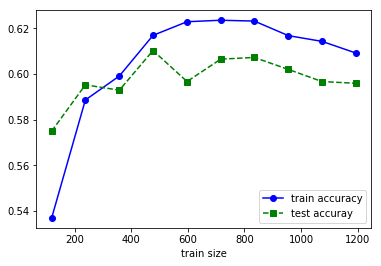

In [20]:
lc_plot(svc, data, 1500)

In [22]:
sizes = [1000, 1200, 1500]
spans = [150, 200, 250]
min_spreads = [0.001, 0.002, 0.005]
C_gamma = {'C': [0.01, 0.05, 0.1, 0.5, 1],
           'gamma': [0.00005, 0.001, 0.005, 0.01, 0.05, 0.1]}

In [23]:
# bests

In [24]:
gs_svc = {}
best_svc = {}
for size in sizes:
    for span in spans:
        for ms in min_spreads:
            print(size, span, ms)
            last = (len(data) - size) // span + 1
            p = Predict(svc, data, size=size, span=span, last=last, min_spread=ms)
            bests = p.gs_bests(C_gamma)
            best_svc[(size, span, ms)] = bests
            ests = p.best_estimators(bests)
            predicts = p.predicts(ests)
            records = p.trade_records(predicts, min_proba=0)
            nav = get_nav(records, data['spread'], trans_cost=0.0005)
            mddd, mdd, ann, calmar, sharpe, win = evaluate(nav)
            gs_svc[(size, span, ms)] = [mddd, mdd.min(), ann, calmar, sharpe, win]

1000 150 0.001
upper limits:
C touch upper limit: 4
gamma touch upper limit: 1
lower limits:
C touch lower limit: 1


1000 150 0.002
upper limits:
C touch upper limit: 6
lower limits:
C touch lower limit: 1
gamma touch lower limit: 1


1000 150 0.005
upper limits:
C touch upper limit: 3


1000 200 0.001
upper limits:
C touch upper limit: 2
gamma touch upper limit: 1
lower limits:
C touch lower limit: 1
gamma touch lower limit: 1


1000 200 0.002
upper limits:
C touch upper limit: 3
lower limits:
gamma touch lower limit: 1


1000 200 0.005


1000 250 0.001
upper limits:
C touch upper limit: 2


1000 250 0.002
upper limits:
C touch upper limit: 5


1000 250 0.005


1200 150 0.001
upper limits:
C touch upper limit: 1
lower limits:
gamma touch lower limit: 2


1200 150 0.002
upper limits:
gamma touch upper limit: 1
lower limits:
gamma touch lower limit: 1


1200 150 0.005
upper limits:
C touch upper limit: 5
lower limits:
gamma touch lower limit: 1


1200 200 0.001
upper limits:
C touch up

In [25]:
gs_svc = pd.DataFrame(gs_svc).T
gs_svc.columns = ['mddd', 'mdd', 'ann', 'calmar', 'sharpe', 'win']

In [26]:
gs_svc

mddd       mdd       ann    calmar    sharpe       win
1000 150 0.001  776.0 -0.201564  0.063777  0.316411  0.267537  0.505731
         0.002  657.0 -0.301354  0.071413  0.236972  0.335387  0.527221
         0.005  776.0 -0.193605  0.081561  0.421273  0.429301  0.509312
     200 0.001  776.0 -0.139439  0.110422  0.791904  0.721210  0.507163
         0.002  657.0 -0.346939  0.053145  0.153182  0.176929  0.507163
         0.005  776.0 -0.278158  0.060208  0.216453  0.236627  0.506447
     250 0.001  480.0 -0.142800  0.107638  0.753765  0.691371  0.520774
         0.002  657.0 -0.415252  0.022137  0.053310 -0.063189  0.507163
         0.005  776.0 -0.184808  0.069044  0.373602  0.314089  0.503582
1200 150 0.001  813.0 -0.292305  0.040385  0.138160  0.087697  0.512542
         0.002  452.0 -0.173280  0.086315  0.498125  0.463603  0.520067
         0.005  276.0 -0.067555  0.170614  2.525534  1.345967  0.540134
     200 0.001  462.0 -0.131526  0.102572  0.779859  0.613044  0.518395
         0.002  333.0 -0.090486  0.129354  1.429546  0.879819  0.527592
         0.005  452.0 -0.136024  0.107179  0.787943  0.657073  0.525920
     250 0.001  456.0 -0.130491  0.120696  0.924936  0.790673  0.523411
         0.002  582.0 -0.124161  0.145877  1.174895  1.058060  0.522575
         0.005  776.0 -0.153793  0.098088  0.637794  0.570919  0.515886
1500 150 0.001  570.0 -0.120721  0.130942  1.084666  0.813390  0.520089
         0.002  605.0 -0.162972  0.128538  0.788713  0.791912  0.522321
         0.005  433.0 -0.082983  0.167088  2.013513  1.152777  0.523438
     200 0.001  459.0 -0.111381  0.117720  1.056913  0.696848  0.511161
         0.002  417.0 -0.105494  0.149661  1.418668  0.985263  0.518973
         0.005  285.0 -0.102550  0.139942  1.364626  0.895009  0.515625
     250 0.001  333.0 -0.098913  0.157579  1.593104  1.060452  0.515625
         0.002  343.0 -0.105494  0.147761  1.400656  0.967443  0.518973
         0.005  424.0 -0.095802  0.181624  1.895822  1.298276  0.530134

In [27]:
gs_svc_ = gs_svc[(gs_svc['ann'] > 0.05) & (gs_svc['calmar'] > 0.5)] # 年化大于10%，前calmar大于1的参数，年化也可以设置为大于5%
best_params_idx = gs_svc_['calmar'].idxmax() # 满足上述条件时，calmar最大的参数
print(gs_svc_.loc[best_params_idx, :])

mddd      276.000000
mdd        -0.067555
ann         0.170614
calmar      2.525534
sharpe      1.345967
win         0.540134
Name: (1200, 150, 0.005), dtype: float64


In [28]:
best_svc[best_params_idx]

{0: {'C': 1, 'gamma': 0.05},
 1: {'C': 0.5, 'gamma': 0.01},
 2: {'C': 1, 'gamma': 0.005},
 3: {'C': 1, 'gamma': 0.01},
 4: {'C': 0.5, 'gamma': 0.005},
 5: {'C': 1, 'gamma': 0.005},
 6: {'C': 1, 'gamma': 0.01},
 7: {'C': 0.05, 'gamma': 5e-05}}

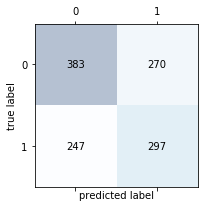

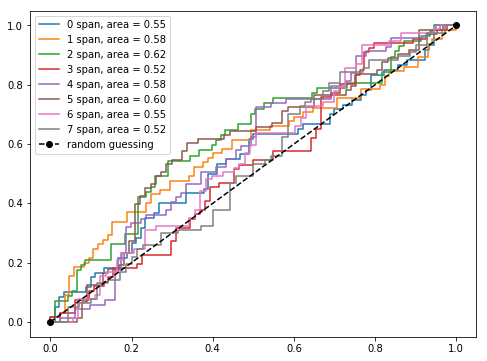

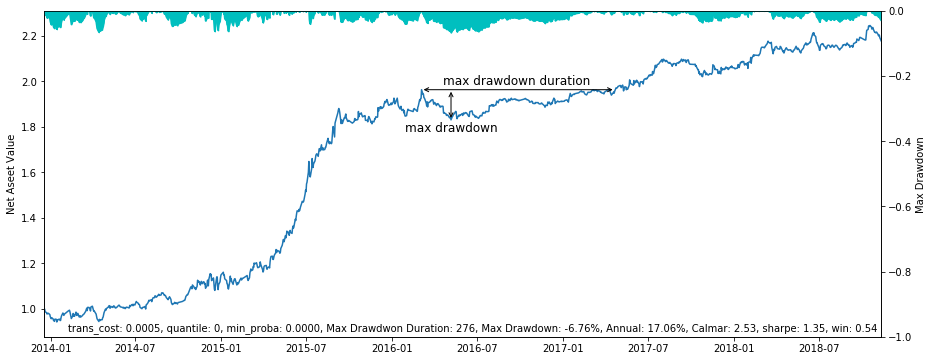

In [29]:
size, span, min_spread = best_params_idx
last = (len(data) - size) // span + 1
p = Predict(svc, data, size=size, span=span, last=last, min_spread=min_spread) 
bests = best_svc[best_params_idx]
ests = p.best_estimators(bests)
predicts = p.predicts(ests)
p.confusion(predicts)
scores = p.scores(ests)
p.roc_plot(ests)
mp = 0
tc= 0.0005
records = p.trade_records(predicts, min_proba=mp)
nav = get_nav(records, data['spread'], trans_cost=tc)
nav_plot(nav, min_spread=min_spread, min_proba=mp, trans_cost=tc)
plt.savefig('style_svc.png')

In [31]:
predicts.head()

,predict,proba
datetime,,
2013-12-17,1.0,0.500000
2013-12-18,1.0,0.480118
2013-12-19,1.0,0.457362
2013-12-20,-1.0,0.720276
2013-12-23,1.0,0.549130


In [32]:
with pd.HDFStore('signal.h5') as store:
    store['signal_svc'] = predicts.predict

In [33]:
bests

{0: {'C': 1, 'gamma': 0.05},
 1: {'C': 0.5, 'gamma': 0.01},
 2: {'C': 1, 'gamma': 0.005},
 3: {'C': 1, 'gamma': 0.01},
 4: {'C': 0.5, 'gamma': 0.005},
 5: {'C': 1, 'gamma': 0.005},
 6: {'C': 1, 'gamma': 0.01},
 7: {'C': 0.05, 'gamma': 5e-05}}

In [34]:
records = p.trade_records(predicts, min_proba=0)
records2 = records.copy()
records2['cut_label2'] = pd.qcut(records2['proba'], 10)

In [35]:
cut_label2 = records2.groupby(['record', 'cut_label2']).count()#.plot(kind='bar')

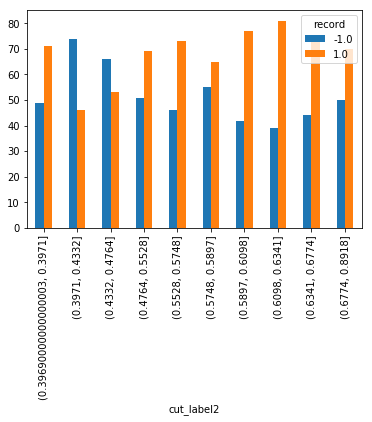

In [36]:
cut_label2['proba'].unstack().T.plot(kind='bar') # 预测的正确次数，并不会随着预测概率的提高而提高